
# Artifact Correction by AJDC-based Blind Source Separation

Blind source separation (BSS) based on approximate joint diagonalization of
Fourier cospectra (AJDC), applied to artifact correction of EEG [1]_.


In [1]:
# Authors: Quentin Barthélemy & David Ojeda.
# EEG signal kindly shared by Marco Congedo.
#
# License: BSD (3-clause)

import gzip
import numpy as np
from scipy.signal import welch
from matplotlib import pyplot as plt

from mne import create_info
from mne.io import RawArray
from mne.viz import plot_topomap
from mne.preprocessing import ICA

from pyriemann.spatialfilters import AJDC
from pyriemann.utils.viz import plot_cospectra

In [2]:
def read_header(fname):
    """Read the header of sample-blinks.txt"""
    with gzip.open(fname, 'rt') as f:
        content = f.readline().split()
        return content[:-1], int(content[-1])

## Load EEG data



In [3]:
fname = 'sample-blinks.txt.gz'
signal_raw = np.loadtxt(fname, skiprows=1).T
ch_names, sfreq = read_header(fname)
ch_count = len(ch_names)
duration = signal_raw.shape[1] / sfreq

## Channel space



Using matplotlib as 2D backend.


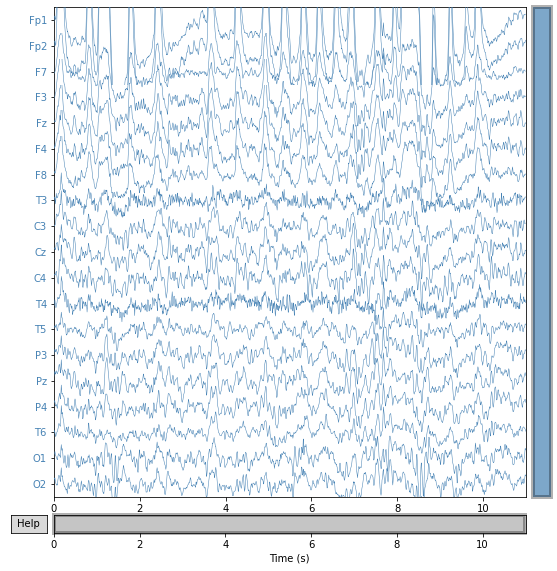

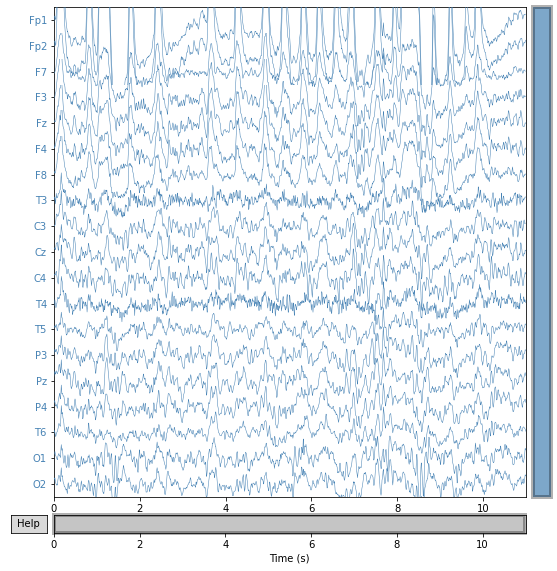

In [4]:
# Plot signal X
ch_info = create_info(ch_names=ch_names, ch_types=['eeg'] * ch_count,
                      sfreq=sfreq)
ch_info.set_montage('standard_1020')
signal = RawArray(signal_raw, ch_info, verbose=False)
signal.plot(duration=duration, start=0, n_channels=ch_count,
            scalings={'eeg': 3e1}, color={'eeg': 'steelblue'},
            title='Original EEG signal', show_scalebars=False)

In [5]:
print(signal_raw.shape)

(19, 1408)


## AJDC: Second-Order Statistics (SOS)-based BSS, diagonalizing cospectra



Condition numbers: 
 array([  1.        ,   2.29766117,   4.09457756,   4.86981696,
         6.09760458,   9.15865458,  13.21748535,  17.74436118,
        26.1024296 ,  27.31744246,  33.78134725,  45.22515539,
        50.61007053,  60.36895283,  73.48533473,  74.73247287,
        92.15600097, 121.30282659, 164.52162547])
Dimension reduction of Whitening on 17 components


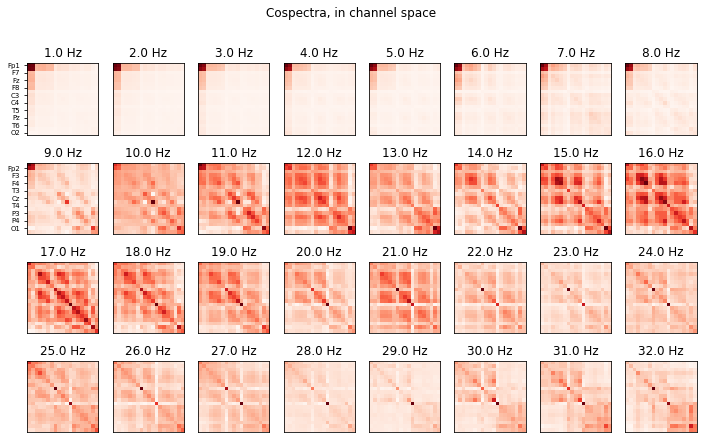

In [15]:
# Compute and diagonalize Fourier cospectral matrices between 1 and 32 Hz
window, overlap = sfreq, 0.5
fmin, fmax = 1, 32
ajdc = AJDC(window=window, overlap=overlap, fmin=fmin, fmax=fmax, fs=sfreq,
            dim_red={'max_cond': 100})
ajdc.fit(signal_raw[np.newaxis, np.newaxis, ...])
freqs = ajdc.freqs_

# Plot cospectra in channel space, after trace-normalization by frequency: each
# cospectrum, associated to a frequency, is a covariance matrix
plot_cospectra(ajdc._cosp_channels, freqs, ylabels=ch_names,
               title='Cospectra, in channel space')

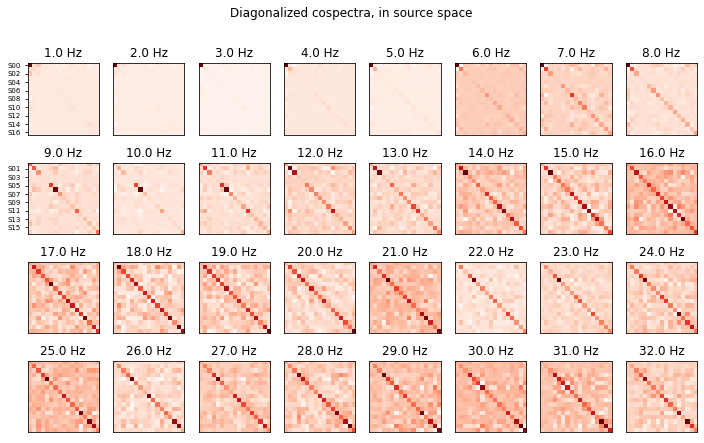

In [16]:
# Plot diagonalized cospectra in source space
sr_count = ajdc.n_sources_
sr_names = ['S' + str(s).zfill(2) for s in range(sr_count)]
plot_cospectra(ajdc._cosp_sources, freqs, ylabels=sr_names,
               title='Diagonalized cospectra, in source space')

## Source space



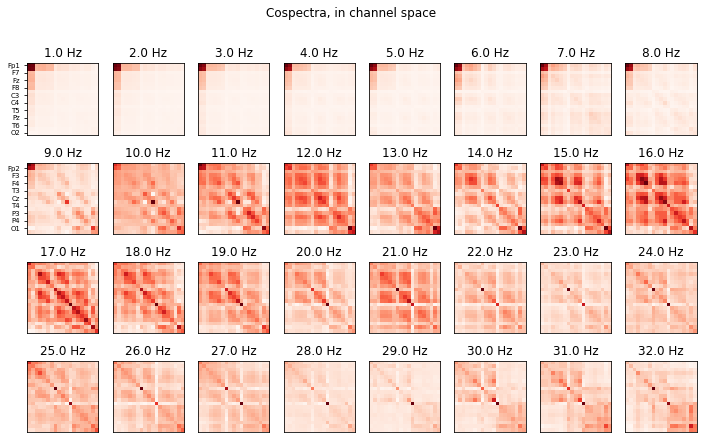

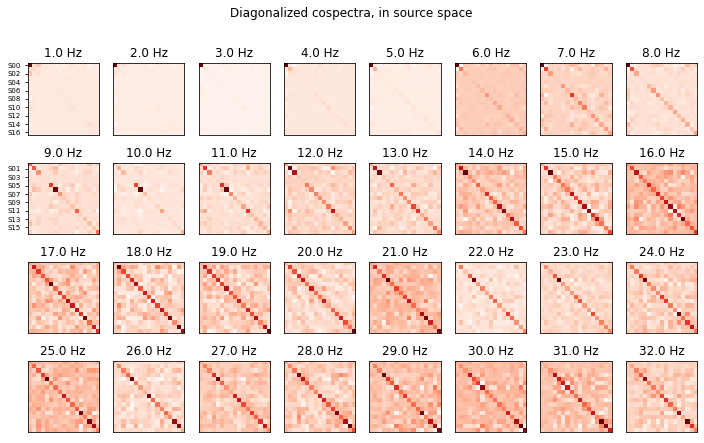

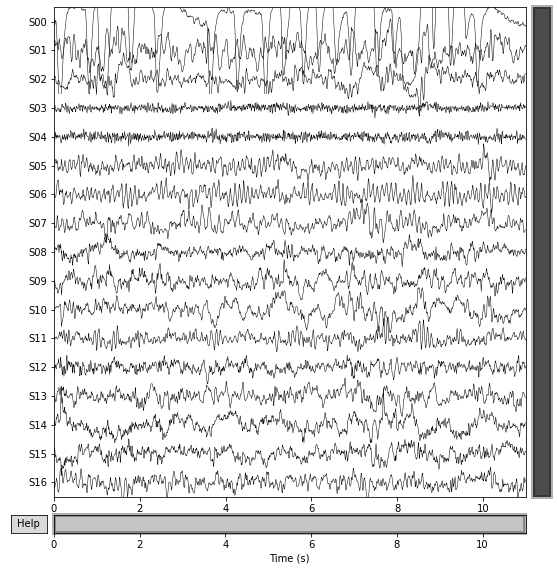

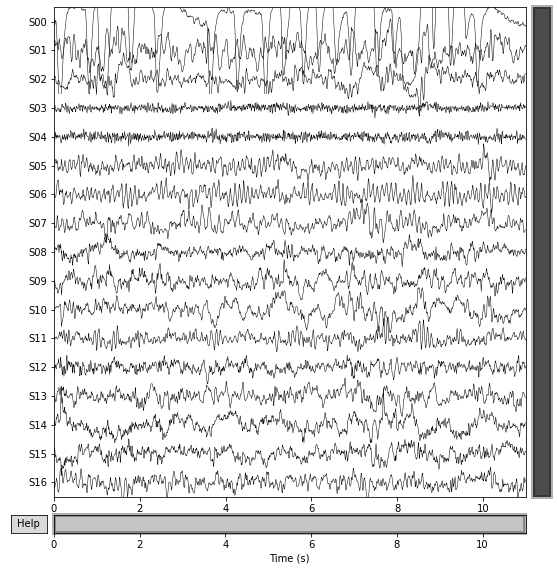

In [17]:
# Estimate sources S applying forward filters B to signal X: S = B X
source_raw = ajdc.transform(signal_raw[np.newaxis, ...])[0]

# Plot sources S
sr_info = create_info(ch_names=sr_names, ch_types=['misc'] * sr_count,
                      sfreq=sfreq)
source = RawArray(source_raw, sr_info, verbose=False)
source.plot(duration=duration, start=0, n_channels=sr_count,
            scalings={'misc': 2e2}, title='EEG sources estimated by AJDC',
            show_scalebars=False)

## Artifact identification



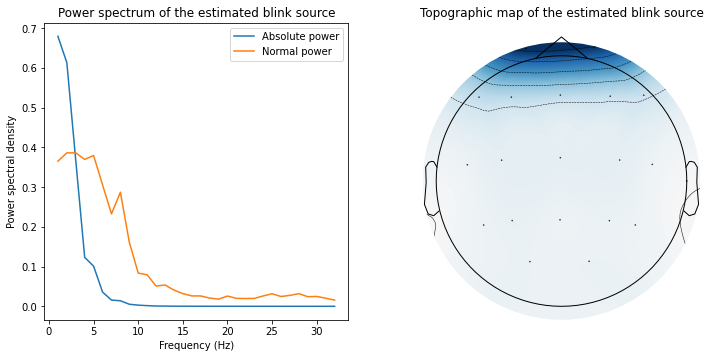

In [18]:
# Identify artifact by eye: blinks are well separated in source S0
blink_idx = 0

# Get normal spectrum, ie power spectrum after trace-normalization
blink_spectrum_norm = ajdc._cosp_sources[:, blink_idx, blink_idx]
blink_spectrum_norm /= np.linalg.norm(blink_spectrum_norm)

# Get absolute spectrum, ie raw power spectrum of the source
f, spectrum = welch(source.get_data(picks=[blink_idx]), fs=sfreq,
                    nperseg=window, noverlap=int(window * overlap))
blink_spectrum_abs = spectrum[0, (f >= fmin) & (f <= fmax)]
blink_spectrum_abs /= np.linalg.norm(blink_spectrum_abs)

# Get topographic map
blink_filter = ajdc.backward_filters_[:, blink_idx]

# Plot spectrum and topographic map of the blink source separated by AJDC
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs[0].set(title='Power spectrum of the estimated blink source',
           xlabel='Frequency (Hz)', ylabel='Power spectral density')
axs[0].plot(freqs, blink_spectrum_abs, label='Absolute power')
axs[0].plot(freqs, blink_spectrum_norm, label='Normal power')
axs[0].legend()
axs[1].set_title('Topographic map of the estimated blink source')
plot_topomap(blink_filter, pos=ch_info, axes=axs[1], extrapolate='box')
fig.savefig('Pham_blink_source.jpg')

## Artifact correction by BSS denoising



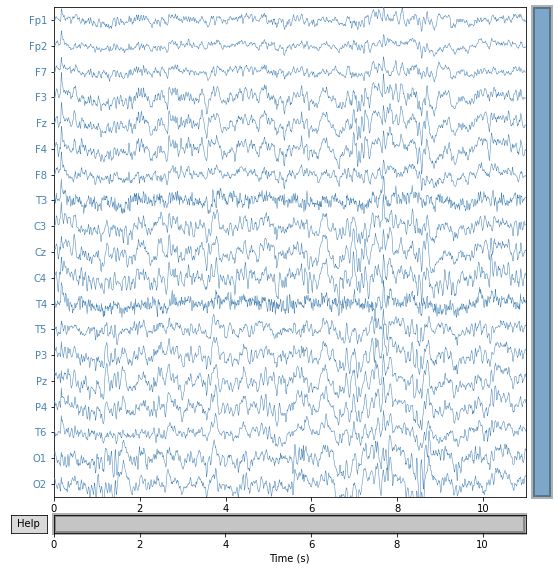

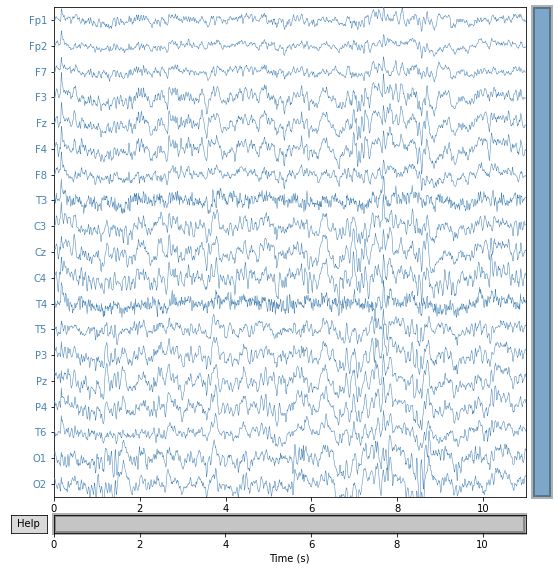

In [10]:
# BSS denoising: blink source is suppressed in source space using activation
# matrix D, and then applying backward filters A to come back to channel space
# Denoised signal: Xd = A D S
signal_denois_raw = ajdc.inverse_transform(source_raw[np.newaxis, ...],
                                           supp=[blink_idx])[0]

# Plot denoised signal Xd
signal_denois = RawArray(signal_denois_raw, ch_info, verbose=False)
signal_denois.plot(duration=duration, start=0, n_channels=ch_count,
                   scalings={'eeg': 3e1}, color={'eeg': 'steelblue'},
                   title='Denoised EEG signal by AJDC', show_scalebars=False)

## Comparison with Independent Component Analysis (ICA)



Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 13 components
 
Fitting ICA took 0.1s.
Creating RawArray with float64 data, n_channels=13, n_times=1408
    Range : 0 ... 1407 =      0.000 ...    10.992 secs
Ready.


C:\Users\Haoze He\AppData\Local\Temp\ipykernel_26272\291012811.py:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(signal, picks='eeg')


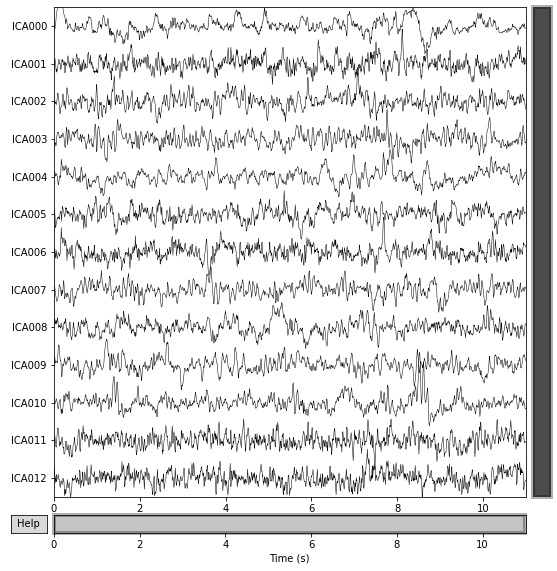

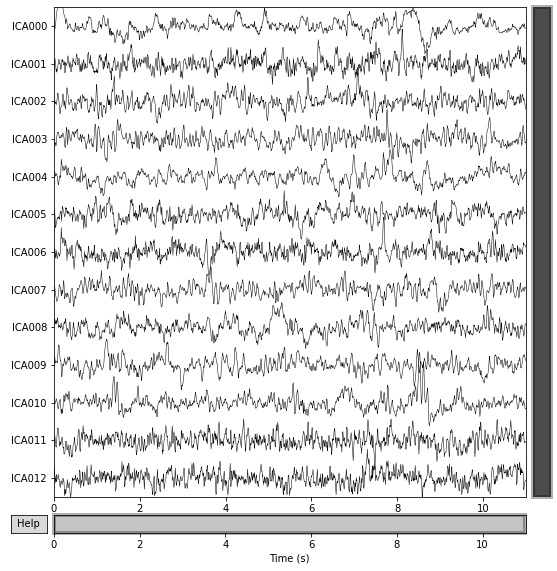

In [11]:
# Infomax-based ICA is a Higher-Order Statistics (HOS)-based BSS, minimizing
# mutual information
ica = ICA(n_components=ajdc.n_sources_, method='infomax', random_state=42)
ica.fit(signal, picks='eeg')

# Plot sources separated by ICA
ica.plot_sources(signal, title='EEG sources estimated by ICA')

# Can you find the blink source?

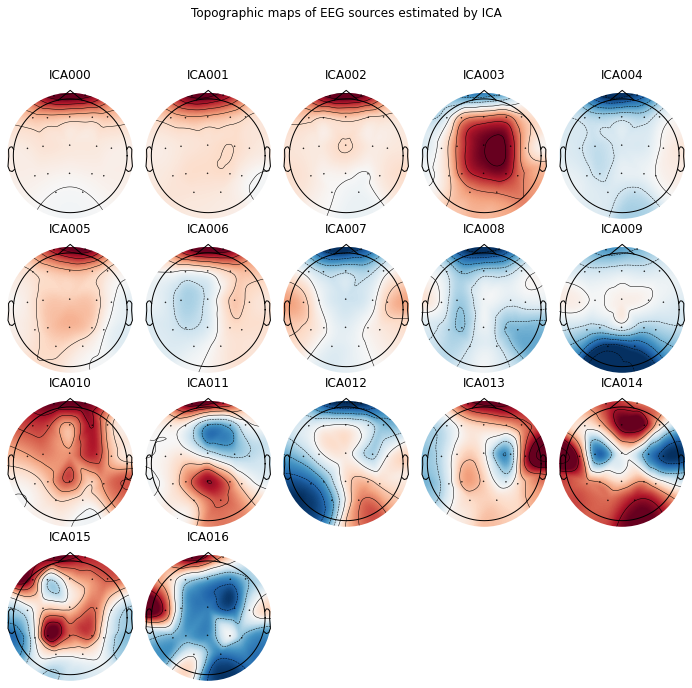

[<MNEFigure size 702x696.24 with 17 Axes>]

In [15]:
# Plot topographic maps of sources separated by ICA
ica.plot_components(title='Topographic maps of EEG sources estimated by ICA')

## References
.. [1] [Online denoising of eye-blinks in electroencephalography](https://hal.archives-ouvertes.fr/hal-01660666/)
   Q. Barthélemy, L. Mayaud, Y. Renard, D. Kim, S.-W. Kang, J. Gunkelman
   and M. Congedo. Clinical Neurophysiology, Elsevier Masson, 2017, 47
   (5-6), pp.371-391

